In [ ]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import mplhep as hep
hep.style.use(hep.style.LHCb2) # make our plots look good
from scipy.stats import crystalball
from scipy.optimize import curve_fit
from scipy.special import erf
from scipy.integrate import quad
import pandas as pd
from scipy.stats import norm

In [ ]:
# Set global font size
plt.rc('font', size=14)          # controls default text size
plt.rc('axes', titlesize=16)     # fontsize of the title
plt.rc('axes', labelsize=13)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=11)    # fontsize of the x tick labels
plt.rc('ytick', labelsize=11)    # fontsize of the y tick labels
plt.rc('legend', fontsize=14)    # fontsize of the legend

In [ ]:
#I concatenate 2016-2018 LLMD data
branches_c= uproot.concatenate(['/eos/lhcb/wg/RD/Lb2Lll/RLambda/Tuples/v206/TupleProcess_EE_MVA/LPT/CL18DDMD/LPT_procTuple.root:Lb2JpsiL_eeTuple/DecayTree','/eos/lhcb/wg/RD/Lb2Lll/RLambda/Tuples/v206/TupleProcess_EE_MVA/LPT/CL16DDMD/LPT_procTuple.root:Lb2JpsiL_eeTuple/DecayTree','/eos/lhcb/wg/RD/Lb2Lll/RLambda/Tuples/v206/TupleProcess_EE_MVA/LPT/CL17DDMD/LPT_procTuple.root:Lb2JpsiL_eeTuple/DecayTree'], expressions=('Lb_q2','Lb_M','Lb_DTF_L0_JPs_PV_M_0','Lb_DTF_L0_JPs_PV_Lambda0_pplus_ID_0','Pi_AtVtx_PE','P_AtVtx_P','Pi_AtVtx_PX','P_AtVtx_PX','Pi_AtVtx_PY','P_AtVtx_PY','Pi_AtVtx_PZ','P_AtVtx_PZ'))




In [ ]:
mass_K0_c= np.sqrt(np.square(branches_c['Pi_AtVtx_PE'] +np.sqrt(np.square(139.57)+np.square(branches_c['P_AtVtx_P'])))
                 - np.square(branches_c['Pi_AtVtx_PX'] +branches_c['P_AtVtx_PX'])
                 - np.square(branches_c['Pi_AtVtx_PY']+branches_c['P_AtVtx_PY'])
                 -np.square(branches_c['Pi_AtVtx_PZ']+branches_c['P_AtVtx_PZ']))

In [ ]:
##SELECTIONS

sel_m_c= abs(branches_c['Lb_q2']) < 11
sel__m_c= abs(branches_c['Lb_q2']) > 6


#cut
#[483.8, 510.2]
up = mass_K0_c> 510.2
down = mass_K0_c < 483.8
[up|down]

combined_1_c= sel_m_c & sel__m_c
combined_2_c = up | down
final_c = combined_1_c& combined_2_c

In [ ]:
#DEFINITIONS
def crystal_ball_left(x, beta, m, mu, sigma):

    #crystalball.pdf(x,beta,m,loc(mu),scale(sigma))= crystalball.pdf(t,beta,m)/scale with t=(x-loc)/scale
    #beta= smaller value = gradual decline; higher value = sharper cutoff
    #m= larger value = more rapid drop-off of the tail

    t = (x - mu) / sigma
    abs_beta = abs(beta)
    C = (m / abs_beta) * (1 / (m - 1)) * np.exp(-abs_beta**2 / 2)
    D = np.sqrt(np.pi / 2) * (1 + erf(abs_beta / np.sqrt(2)))
    N = 1 / (sigma * (C + D))



    left = np.zeros_like(x) # np.array same shape and size as x but filled with zeros
        # Gaussian part for t > -beta
    left[t > -abs_beta] = np.exp(-0.5 * t[t > -abs_beta]**2) #Only t> -beta are updated in the left array
        # Power-law tail for t <= -beta
    A = (m / abs_beta)**m * np.exp(-0.5 * abs_beta**2)
    B = m / abs_beta - abs_beta
    left[t <= -abs_beta] = A * (B - t[t <= -abs_beta])**-m

    return N*left


#right-tailed Crystal Ball function
def crystal_ball_right(x, beta, m, mu, sigma):
    t = (x - mu) / sigma
    abs_beta = abs(beta)
    C = (m / abs_beta) * (1 / (m - 1)) * np.exp(-abs_beta**2 / 2)
    D = np.sqrt(np.pi / 2) * (1 + erf(abs_beta / np.sqrt(2)))
    N = 1 / (sigma * (C + D))


    right = np.zeros_like(x)
        # Gaussian part for t < beta
    right[t < beta ] = np.exp(-0.5 * t[t < beta ]**2)
        # Power-law tail for t >= beta
    A = (m / abs_beta)**m * np.exp(-0.5 * abs_beta **2)
    B = m / abs_beta  - abs_beta
    right[t >= beta ] = A * (B + t[t >= beta ])**-m

    return N*right


In [ ]:
#Define particle-anti selection
protons = branches_c['Lb_DTF_L0_JPs_PV_Lambda0_pplus_ID_0'] > 0
antiprotons= branches_c['Lb_DTF_L0_JPs_PV_Lambda0_pplus_ID_0'] < 0

In [ ]:
#Define the variables
Lb_DTF_L0_JPs_PV_M_0_selection = branches_c['Lb_DTF_L0_JPs_PV_M_0'][final_c]
Lb_DTF_L0_JPs_PV_M_0_particle = branches_c['Lb_DTF_L0_JPs_PV_M_0'][final_c & protons]
Lb_DTF_L0_JPs_PV_M_0_antiparticle = branches_c['Lb_DTF_L0_JPs_PV_M_0'][final_c & antiprotons]
print(np.sum(Lb_DTF_L0_JPs_PV_M_0_selection))
print(np.sum(Lb_DTF_L0_JPs_PV_M_0_particle ))
print(np.sum(Lb_DTF_L0_JPs_PV_M_0_antiparticle))



In [ ]:
#background particle
##Background FOR PARTICLE def: a * np.exp(-b * x)


data = Lb_DTF_L0_JPs_PV_M_0_particle.to_numpy()

#def background_func(x,a,b, normalization):
#   return normalization*(a*x+b)

def exp_decay(x, a, b):
    return a * np.exp(-b * x)

#same n of bins in histogram and fitted data
min_x = 5200
max_x = 6200
n_bins = 250



# Create histogram
bin_contents, bin_edges = np.histogram(data, bins=n_bins, range=(min_x, max_x))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
y_errors = np.sqrt(bin_contents)


if len(bin_contents) == 0:
    raise ValueError("The histogram is empty. Please check the input data and binning range.")


mask = (bin_centers < 5550) | (bin_centers > 5650)
bin_centers_fit = bin_centers[mask]
bin_contents_fit = bin_contents[mask]
errors_fit = y_errors[mask]


initial_guesses = [300, 0.001]

#curve_fit(f, xdata, ydata, p0, bounds= lower and upper bounds for parameter)
#popt = optimal values for parameters
#pcov = covariance matrix of parameter estimates
popt, pcov = curve_fit(exp_decay, bin_centers_fit, bin_contents_fit, p0=initial_guesses)
pcov_errors = np.sqrt(np.diag(pcov))
# Extract the optimal parameters
a_opt, b_opt = popt

# Generate the fitted curve for plotting

x_fit_left = np.linspace(min_x, 5550, 1000)  # For x < 5500
x_fit_right = np.linspace(5650, max_x, 1000)  # For x > 6000
y_fitted_left = exp_decay(x_fit_left, *popt)
y_fitted_right = exp_decay(x_fit_right, *popt)


# Plot the histogram of the data and the fitted curve
plt.figure(figsize=(10, 6))
plt.errorbar(bin_centers, bin_contents, yerr=y_errors, fmt='o',color='black', label='Data', markersize=3, capsize=1.5, elinewidth=1.5)

plt.plot(x_fit_left, y_fitted_left, label="Fitted Background (x < 5500)", color="red", lw=1)
plt.plot(x_fit_right, y_fitted_right, label="Fitted Background (x > 6000)", color="blue", lw=1)
plt.title(r'Double-Sided Crystal Ball Fit to $\Lambda_b^0$ and $\bar{\Lambda}_b^0$')
plt.xlabel(r'M($\Lambda J/\psi$ ) [MeV/$c^2$]')
plt.ylabel('Candidates per 30 MeV/$c^2$')
plt.legend()
plt.grid(True)
plt.show()

#Optimal values for parameters
print("Optimized parameters and errors:")
print(f"a_opt = {a_opt}± {pcov_errors[0]}")
print(f"b_opt = {b_opt}± {pcov_errors[1]}")

pcov

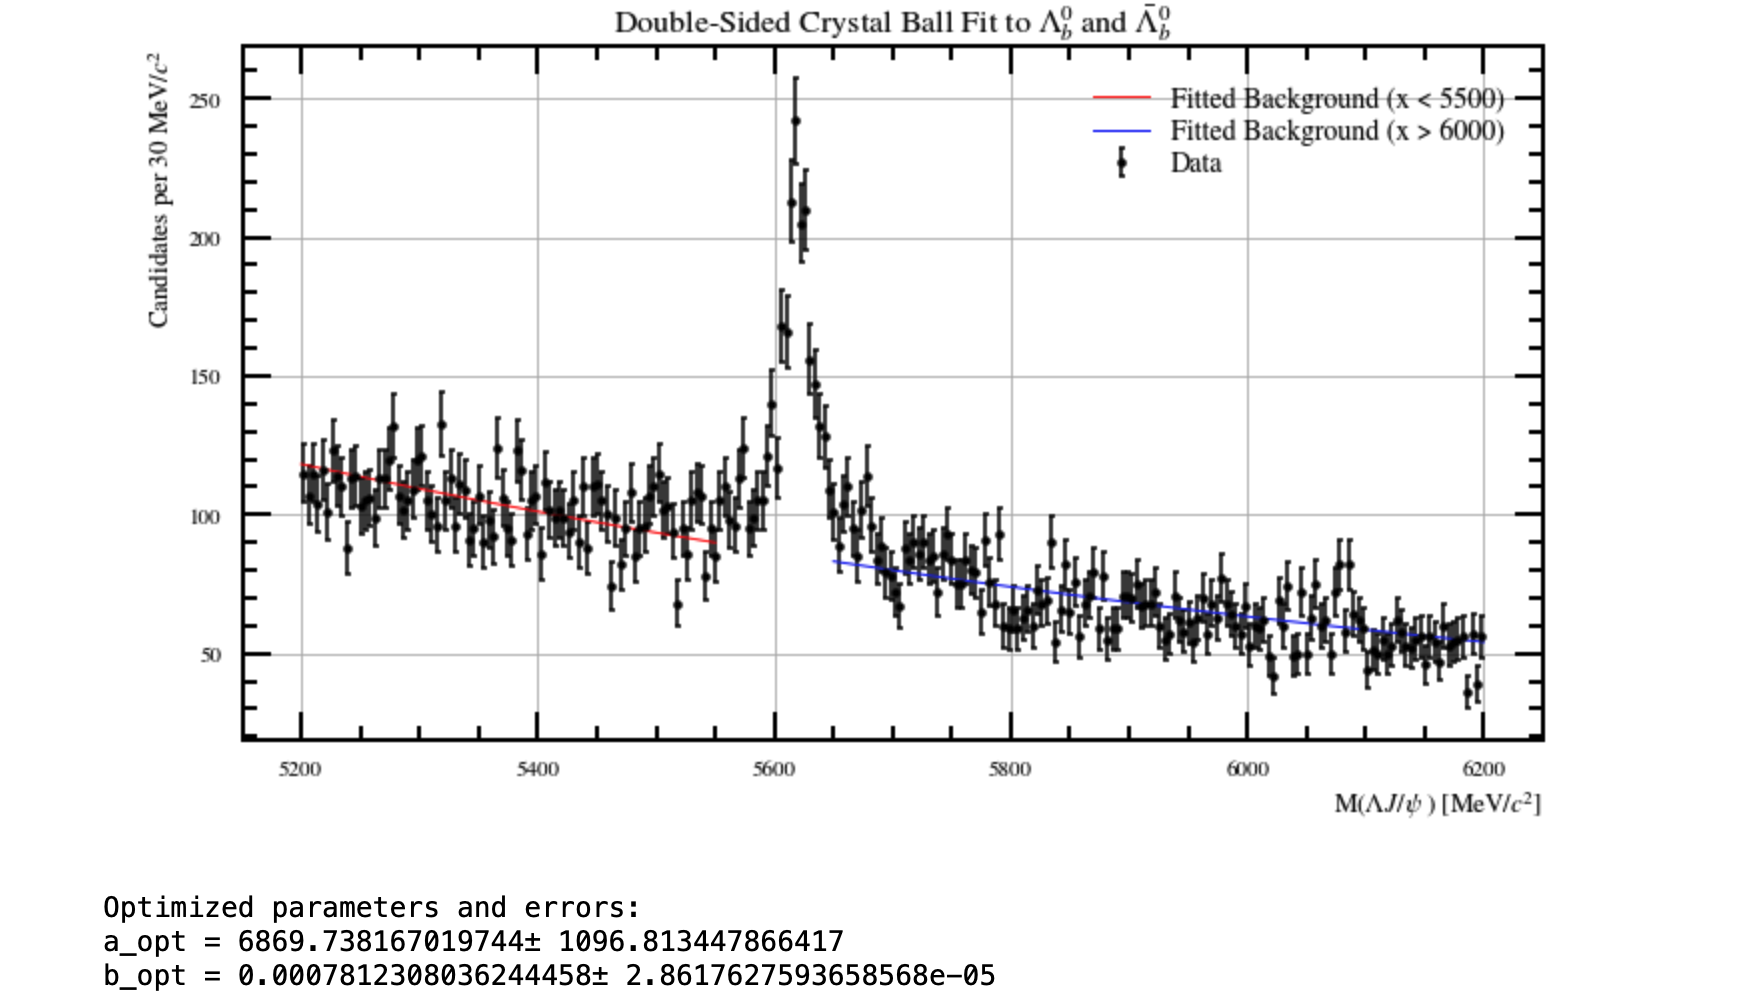

In [ ]:
# PARTICLE FIT
Lb_DTF_L0_JPs_PV_M_0_particle = branches_c['Lb_DTF_L0_JPs_PV_M_0'][final_c & protons]
data = Lb_DTF_L0_JPs_PV_M_0_particle.to_numpy()

a_optg = 6057.6738420415195
b_optg = 0.0007967978923393356

beta_leftg = 0.441620855422896
m_leftg = 3.071226204568538
beta_rightg = 0.3043715310121759
m_rightg = 4.5665099791607195
mug = 5618.999323758905
sigmag = 8.96086813882579
normalization_pleftg = 24449.016394637463
normalization_prightg = 22384.726574835724

def double_sided_crystal_ball(x, beta_L, m_L, beta_R, m_R, mu, sigma, normalization_pL, normalization_pR):
    left_side= normalization_pL*crystal_ball_left(x, beta_L, m_L, mu, sigma)
    right_side= normalization_pR*crystal_ball_right(x, beta_R, m_R, mu, sigma)


    return left_side+right_side

def exp_decay(x, a, b):
    return a * np.exp(-b * x)

def back_and_signal(x, a, b, beta_L, m_L, beta_R, m_R, mu, sigma, normalization_pL, normalization_pR):
    left_side= normalization_pL*crystal_ball_left(x, beta_L, m_L, mu, sigma)
    right_side= normalization_pR*crystal_ball_right(x, beta_R, m_R, mu, sigma)


    return left_side+right_side+ a * np.exp(-b * x)

#same n of bins in histogram and fitted data
min_x = 5250
max_x = 6150
n_bins = 275


# Create histogram
bin_contents, bin_edges = np.histogram(data, bins=n_bins, range=(min_x, max_x))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
y_errors = np.sqrt(bin_contents)

# Check if bin_contents is non-empty
if len(bin_contents) == 0:
    raise ValueError("The histogram is empty. Please check the input data and binning range.")


initial_guesses = [a_optg, b_optg ,beta_leftg,m_leftg,beta_rightg,m_rightg,mug,sigmag,normalization_pleftg ,normalization_prightg ]



popt, pcov = curve_fit(back_and_signal, bin_centers, bin_contents, p0=initial_guesses)
pcov_errors_p = np.sqrt(np.diag(pcov))


a_opt, b_opt, beta_L_opt, m_L_opt, beta_R_opt, m_R_opt, mu_opt, sigma_opt, normalization_pL_opt, normalization_pR_opt= popt



# Generate the fitted curve for plotting
x_fit = np.linspace(min_x, max_x, 5000)
b_s_fitted = back_and_signal(x_fit, *popt)

#a_opt, b_opt, c_opt, d_opt, normalization_opt
b_fitted=exp_decay(x_fit, a_opt, b_opt)

y_signal = double_sided_crystal_ball(x_fit, beta_L_opt, m_L_opt, beta_R_opt, m_R_opt, mu_opt, sigma_opt, normalization_pL_opt, normalization_pR_opt)

# Plot the histogram of the data and the fitted curve
plt.figure(figsize=(10, 6))

plt.errorbar(bin_centers, bin_contents, yerr=y_errors, fmt='o',color='black', label='Data', markersize=3, capsize=1.5, elinewidth=1.5)

plt.plot(x_fit, b_s_fitted, label="Total Fit (Signal + Background)", color="red", lw=1)

plt.plot(x_fit, b_fitted, label="Combinatorial Background", color="blue", lw=1, linestyle='--')

plt.plot(x_fit, y_signal, label="Fitted Signal", color="green", lw=1, linestyle=':')


plt.xlabel(r'$\Lambda_b^0$ mass [MeV/$c^2$]')
plt.ylabel('Number of events per 4 MeV/$c^2$')
plt.legend()

plt.show()
# Print optimized parameters and errors
print("Optimized parameters and errors:")
print(f"a_opt = {a_opt}± {pcov_errors_p[0]}")
print(f"b_opt = {b_opt}± {pcov_errors_p[1]}")
print(f"beta_left = {beta_L_opt} ± {pcov_errors_p[2]}")
print(f"m_left = {m_L_opt} ± {pcov_errors_p[3]}")
print(f"beta_right = {beta_R_opt} ± {pcov_errors_p[4]}")
print(f"m_right = {m_R_opt} ± {pcov_errors_p[5]}")
print(f"mu = {mu_opt} ± {pcov_errors_p[6]}")
print(f"sigma = {sigma_opt} ± {pcov_errors_p[7]}")
print(f"normalization_left = {normalization_pL_opt} ± {pcov_errors_p[8]}")
print(f"normalization_right = {normalization_pR_opt} ± {pcov_errors_p[9]}")


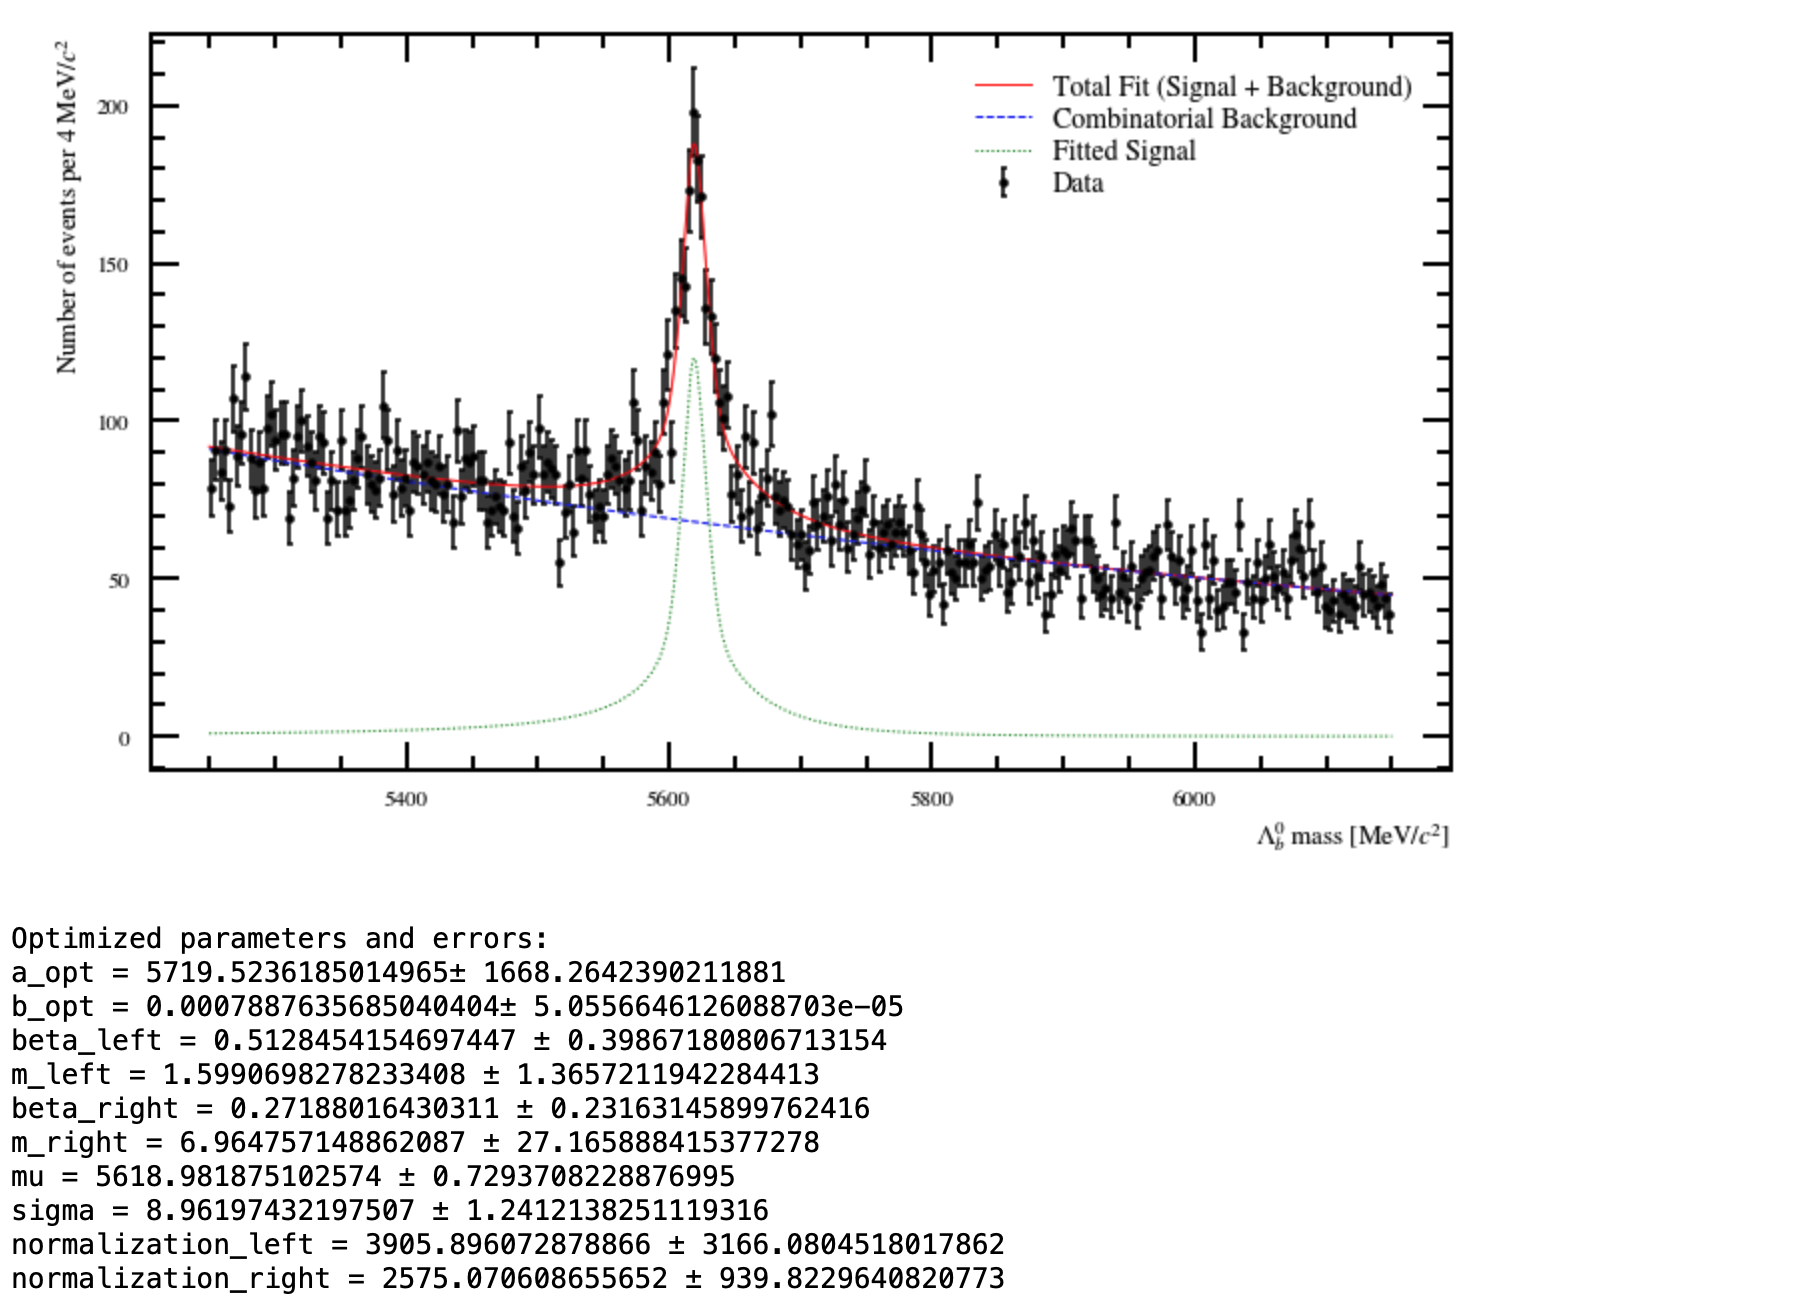

In [ ]:
#background antiparticle
##Background FOR ANTIPARTICLE def: a * np.exp(-b * x)


data = Lb_DTF_L0_JPs_PV_M_0_antiparticle.to_numpy()

#def background_func(x,a,b, normalization):
#   return normalization*(a*x+b)

def exp_decay(x, a, b):
    return a * np.exp(-b * x)

#same n of bins in histogram and fitted data
min_x = 5200
max_x = 6200
n_bins = 250



# Create histogram
bin_contents, bin_edges = np.histogram(data, bins=n_bins, range=(min_x, max_x))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
y_errors = np.sqrt(bin_contents)


if len(bin_contents) == 0:
    raise ValueError("The histogram is empty. Please check the input data and binning range.")


mask = (bin_centers < 5550) | (bin_centers > 5750)
bin_centers_fit = bin_centers[mask]
bin_contents_fit = bin_contents[mask]
errors_fit = y_errors[mask]


initial_guesses = [300, 0.001]

#curve_fit(f, xdata, ydata, p0, bounds= lower and upper bounds for parameter)
#popt = optimal values for parameters
#pcov = covariance matrix of parameter estimates
popt, pcov = curve_fit(exp_decay, bin_centers_fit, bin_contents_fit, p0=initial_guesses)
pcov_errors = np.sqrt(np.diag(pcov))
# Extract the optimal parameters
a_opt, b_opt = popt

# Generate the fitted curve for plotting

x_fit_left = np.linspace(min_x, 5550, 1000)  # For x < 5500
x_fit_right = np.linspace(5750, max_x, 1000)  # For x > 6000
y_fitted_left = exp_decay(x_fit_left, *popt)
y_fitted_right = exp_decay(x_fit_right, *popt)


# Plot the histogram of the data and the fitted curve
plt.figure(figsize=(10, 6))
plt.errorbar(bin_centers, bin_contents, yerr=y_errors, fmt='o',color='black', label='Data', markersize=3, capsize=1.5, elinewidth=1.5)

plt.plot(x_fit_left, y_fitted_left, label="Fitted Background (x < 5500)", color="red", lw=1)
plt.plot(x_fit_right, y_fitted_right, label="Fitted Background (x > 6000)", color="blue", lw=1)
plt.title(r'Double-Sided Crystal Ball Fit to $\Lambda_b^0$ and $\bar{\Lambda}_b^0$')
plt.xlabel(r'M($\Lambda J/\psi$ ) [MeV/$c^2$]')
plt.ylabel('Candidates per 30 MeV/$c^2$')
plt.legend()
plt.grid(True)
plt.show()

#Optimal values for parameters
print("Optimized parameters and errors:")
print(f"a_opt = {a_opt}± {pcov_errors[0]}")
print(f"b_opt = {b_opt}± {pcov_errors[1]}")

pcov

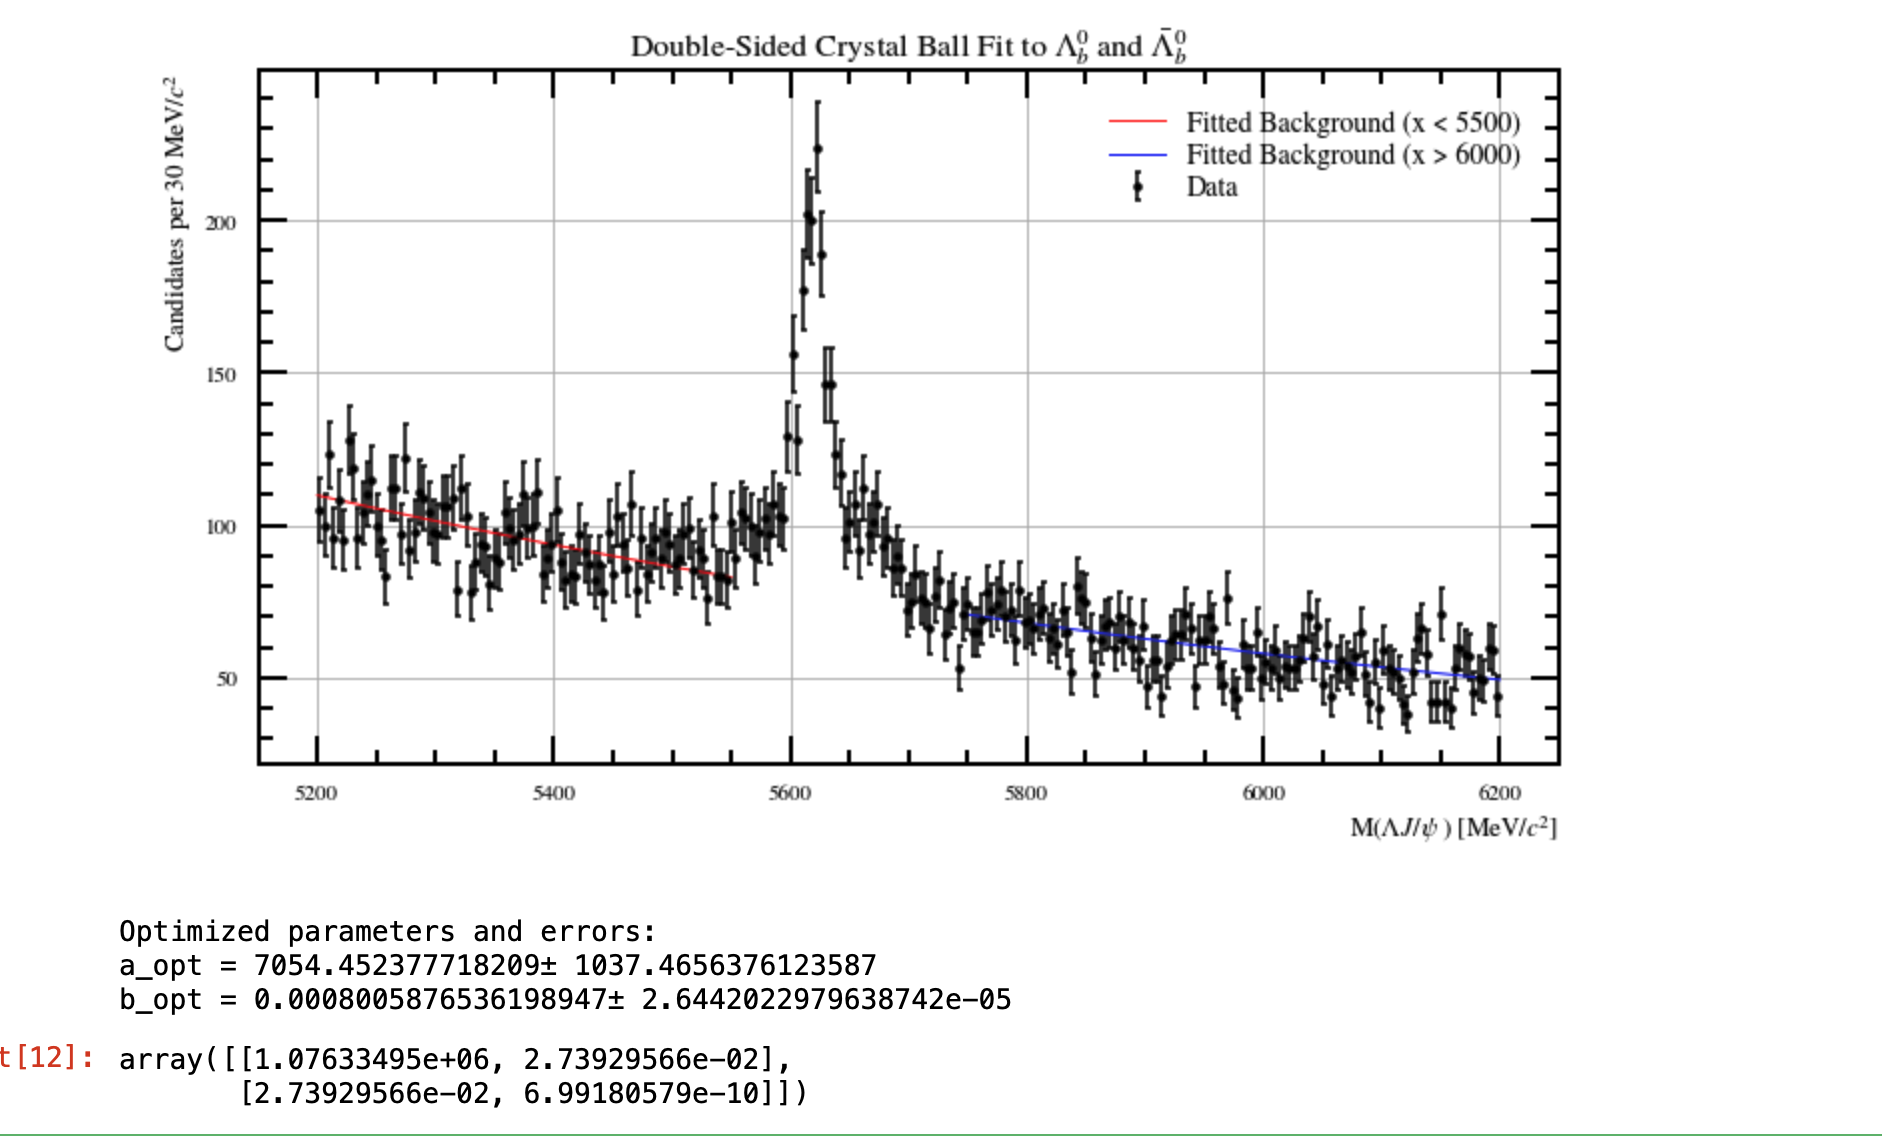

In [ ]:
#Fit antiparticle

Lb_DTF_L0_JPs_PV_M_0_antiparticle = branches_c['Lb_DTF_L0_JPs_PV_M_0'][final_c & antiprotons]
data = Lb_DTF_L0_JPs_PV_M_0_antiparticle.to_numpy()

a_optg = 5903.350336316168
b_optg = 0.0008046373498561484

beta_leftg = 0.34110178962182075
m_leftg = 6.223509115699684
beta_rightg = 0.3580539055973261
m_rightg = 3.5391441401589248
mug = 5619.889583539263
sigmag = 9.097394799158135
normalization_aleftg = 22752.1830958027
normalization_arightg = 22346.155196019838

def double_sided_crystal_ball(x, beta_L, m_L, beta_R, m_R, mu, sigma, normalization_aL, normalization_aR):
    left_side= normalization_aL*crystal_ball_left(x, beta_L, m_L, mu, sigma)
    right_side= normalization_aR*crystal_ball_right(x, beta_R, m_R, mu, sigma)


    return left_side+right_side

def exp_decay(x, a, b):
    return a * np.exp(-b * x)

def back_and_signal(x, a, b, beta_L, m_L, beta_R, m_R, mu, sigma, normalization_aL, normalization_aR):
    left_side= normalization_aL*crystal_ball_left(x, beta_L, m_L, mu, sigma)
    right_side= normalization_aR*crystal_ball_right(x, beta_R, m_R, mu, sigma)


    return left_side+right_side+ a * np.exp(-b * x)

#same n of bins in histogram and fitted data
min_x = 5250
max_x = 6150
n_bins = 275

# Create histogram
bin_contents, bin_edges = np.histogram(data, bins=n_bins, range=(min_x, max_x))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
y_errors = np.sqrt(bin_contents)

# Check if bin_contents is non-empty
if len(bin_contents) == 0:
    raise ValueError("The histogram is empty. Please check the input data and binning range.")


initial_guesses = [a_optg, b_optg ,beta_leftg,m_leftg,beta_rightg,m_rightg,mug,sigmag,normalization_aleftg ,normalization_arightg ]



popt, pcov = curve_fit(back_and_signal, bin_centers, bin_contents, p0=initial_guesses)
pcov_errors_a = np.sqrt(np.diag(pcov))


a_opt, b_opt, beta_L_opt, m_L_opt, beta_R_opt, m_R_opt, mu_opt, sigma_opt, normalization_aL_opt, normalization_aR_opt= popt



# Generate the fitted curve for plotting
x_fit = np.linspace(min_x, max_x, 5000)
b_s_fitted = back_and_signal(x_fit, *popt)

#a_opt, b_opt, c_opt, d_opt, normalization_opt
b_fitted=exp_decay(x_fit, a_opt, b_opt)

y_signal = double_sided_crystal_ball(x_fit, beta_L_opt, m_L_opt, beta_R_opt, m_R_opt, mu_opt, sigma_opt, normalization_aL_opt, normalization_aR_opt)

# Plot the histogram of the data and the fitted curve
plt.figure(figsize=(10, 6))

plt.errorbar(bin_centers, bin_contents, yerr=y_errors, fmt='o',color='black', label='Data', markersize=3, capsize=1.5, elinewidth=1.5)

plt.plot(x_fit, b_s_fitted, label="Total Fit (Signal + Background)", color="red", lw=1)

plt.plot(x_fit, b_fitted, label="Combinatorial Background", color="blue", lw=1, linestyle='--')

plt.plot(x_fit, y_signal, label="Fitted Signal", color="green", lw=1, linestyle=':')


plt.xlabel(r'$\overline{\lambda^{0}_{b}}$ mass [MeV/$c^2$]')
plt.ylabel('Number of events per 4 MeV/$c^2$')
plt.legend()

plt.show()
# Print optimized parameters and errors
print("Optimized parameters and errors:")
print(f"a_opt = {a_opt}± {pcov_errors_a[0]}")
print(f"b_opt = {b_opt}± {pcov_errors_a[1]}")
print(f"beta_left = {beta_L_opt} ± {pcov_errors_a[2]}")
print(f"m_left = {m_L_opt} ± {pcov_errors_a[3]}")
print(f"beta_right = {beta_R_opt} ± {pcov_errors_a[4]}")
print(f"m_right = {m_R_opt} ± {pcov_errors_a[5]}")
print(f"mu = {mu_opt} ± {pcov_errors_a[6]}")
print(f"sigma = {sigma_opt} ± {pcov_errors_a[7]}")
print(f"normalization_left = {normalization_aL_opt} ± {pcov_errors_a[8]}")
print(f"normalization_right = {normalization_aR_opt} ± {pcov_errors_a[9]}")


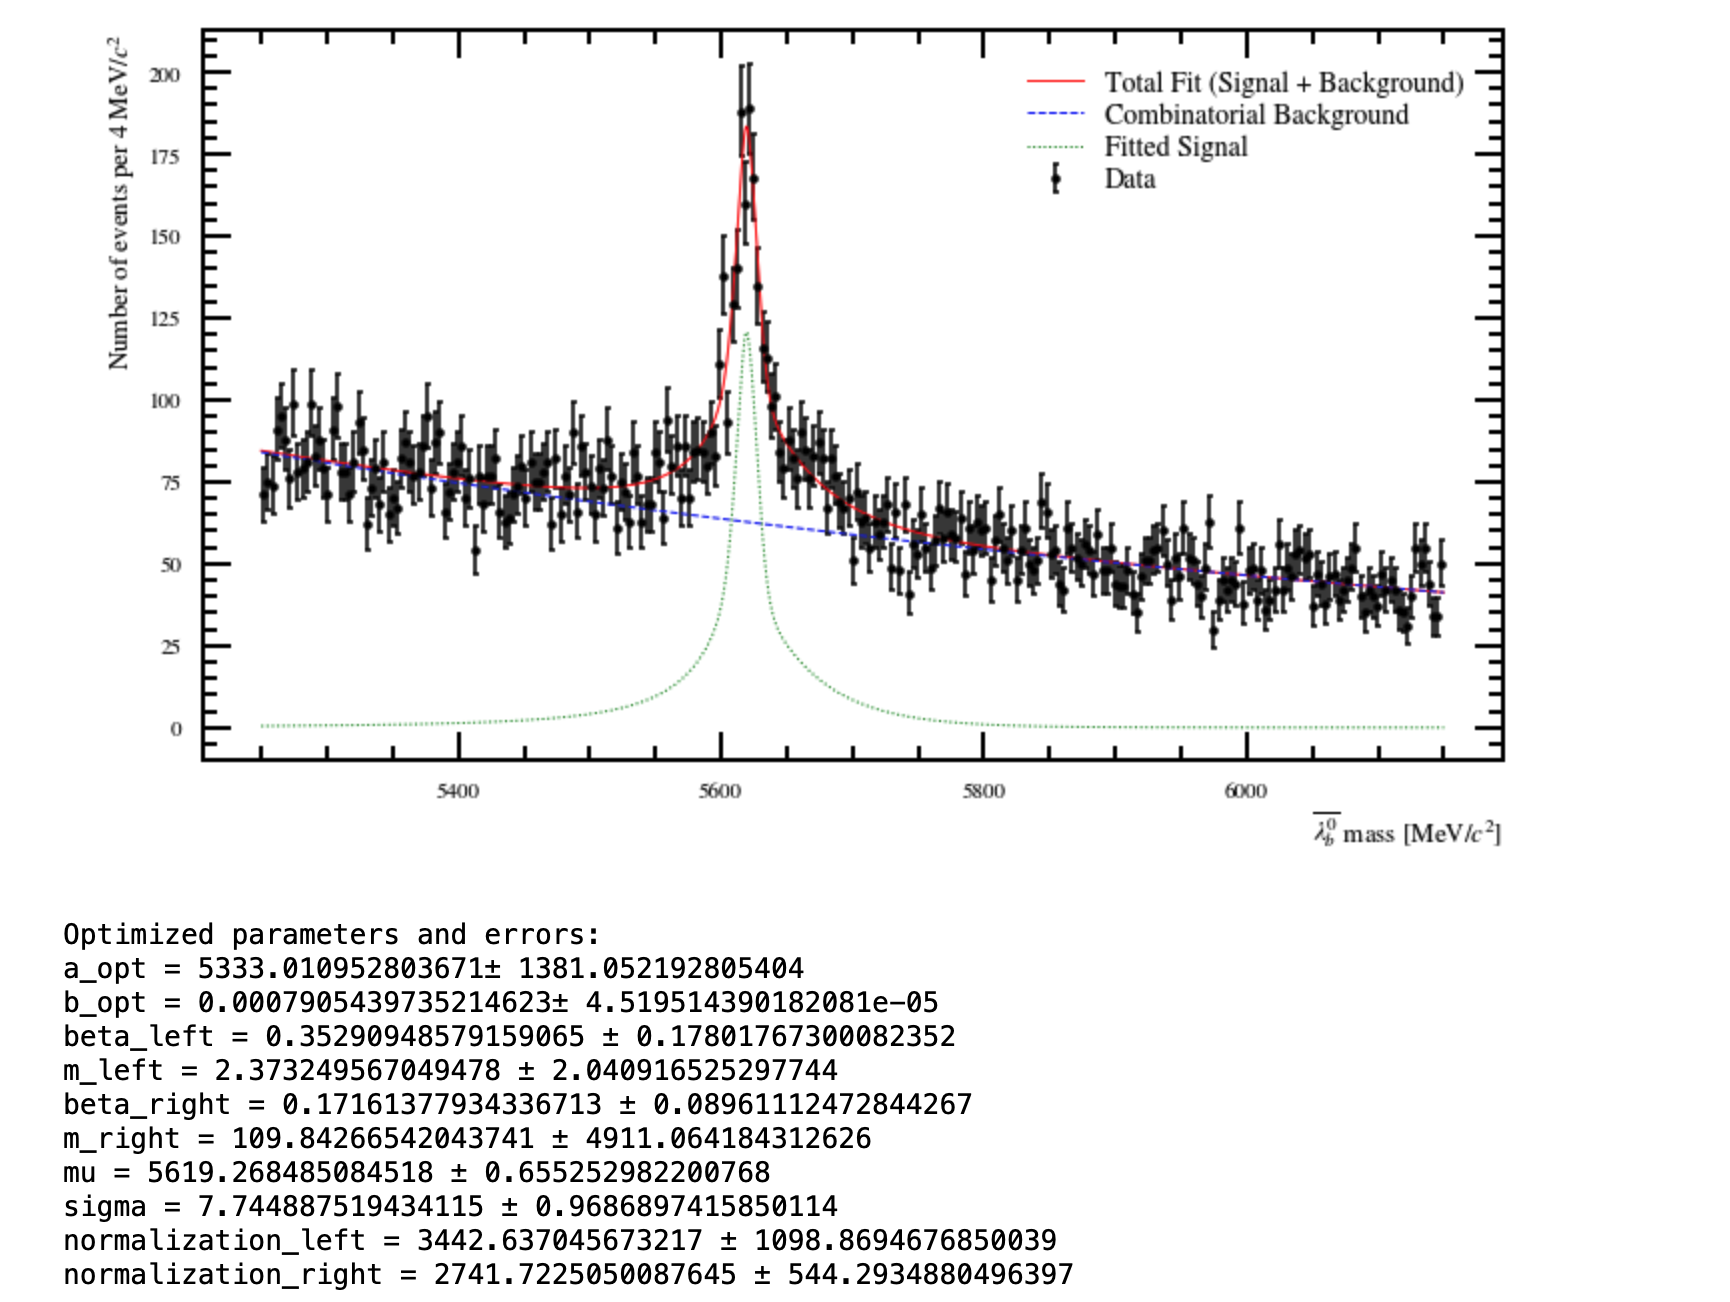

In [ ]:
#Particles
N_particles = (normalization_pL_opt+normalization_pR_opt)/3.3
print(N_particles)

#Antiparticles
N_antiparticles = (normalization_aL_opt+normalization_aR_opt)/3.3
print(N_antiparticles)

asymmetry_ratio = (N_particles-N_antiparticles)/(N_particles+N_antiparticles)
print(asymmetry_ratio)

N_pL_error = pcov_errors_p[8]
N_pR_error = pcov_errors_p[9]
N_aL_error = pcov_errors_a[8]
N_aR_error = pcov_errors_a[9]

N_particle_error = np.sqrt(N_pL_error**2 + N_pR_error**2)/3.3
N_antiparticle_error= np.sqrt(N_aL_error**2 + N_aR_error**2)/3.3
print(N_particle_error)
print(N_antiparticle_error)


dA_dN_particle = 2 * N_antiparticles / (N_particles + N_antiparticles)**2
dA_dN_antiparticle = -2 * N_particles / (N_particles + N_antiparticles)**2

delta_A = np.sqrt((dA_dN_particle * N_particle_error)**2 + (dA_dN_antiparticle * N_antiparticle_error)**2)
print(delta_A)


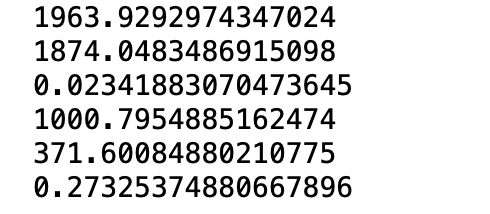